In [1]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [2]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
for i in range(0, 10):
    inputImageDir = './input/' + str(i) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [3]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, num_classes):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        res = self.linear(x)
        res = self.activate(res)
        return res

In [4]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [5]:
# Parameters of training
input_size = 256
num_classes = 256
learning_rate = 0.001
batch_size = 10
num_epochs = 600

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Perceptron(input_size=input_size, num_classes=num_classes).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# Step 3
def train(dataloader, model, num_epochs):
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = [] 
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu, label_cpu = data['data'], data['label']
            if torch.cuda.is_available():
                real_cpu = real_cpu.cuda() 
                label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output

# Start training        
output = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2784 MAE: 0.5138 Mean Error: 0.4219 STD: 0.3169
[10/600] Loss: 0.0449 MAE: 0.1617 Mean Error: 0.0988 STD: 0.1875
[20/600] Loss: 0.0310 MAE: 0.0922 Mean Error: 0.0352 STD: 0.1724
[30/600] Loss: 0.0282 MAE: 0.0784 Mean Error: 0.0218 STD: 0.1667
[40/600] Loss: 0.0265 MAE: 0.0740 Mean Error: 0.0177 STD: 0.1619
[50/600] Loss: 0.0250 MAE: 0.0710 Mean Error: 0.0154 STD: 0.1575
[60/600] Loss: 0.0237 MAE: 0.0691 Mean Error: 0.0147 STD: 0.1531
[70/600] Loss: 0.0224 MAE: 0.0677 Mean Error: 0.0143 STD: 0.1489
[80/600] Loss: 0.0212 MAE: 0.0662 Mean Error: 0.0132 STD: 0.1449
[90/600] Loss: 0.0200 MAE: 0.0646 Mean Error: 0.0129 STD: 0.1409
[100/600] Loss: 0.0190 MAE: 0.0630 Mean Error: 0.0125 STD: 0.1371
[110/600] Loss: 0.0179 MAE: 0.0615 Mean Error: 0.0121 STD: 0.1334
[120/600] Loss: 0.0170 MAE: 0.0599 Mean Error: 0.0118 STD: 0.1298
[130/600] Loss: 0.0161 MAE: 0.0584 Mean Error: 0.0115 STD: 0.1264
[140/600] Loss: 0.0152 MAE: 0.0569 Mean Error: 0.0112 STD: 0.1230
[150/600] Loss: 0.014

In [7]:
# Step 4
# Step 4a
# Export the image after training
# Before executing this block, create a folder called "output"
if not os.path.exists('./output'):
    os.mkdir('./output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, 'net.pkl')
output_dataset = np.zeros([10, 256])
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    output_path = './output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(10, 256)


In [8]:
# Step 4b
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        print('Fh_numerator: %s' % Fh_numerator)
        print('Fh_denominator: %s' % Fh_denominator)
        Fh_array[j] = Fh
    return Fh_array

In [9]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [10]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

Fh_numerator: 25
Fh_denominator: 25
Fh_numerator: 37
Fh_denominator: 37
Fh_numerator: 60
Fh_denominator: 60
Fh_numerator: 83
Fh_denominator: 83
Fh_numerator: 105
Fh_denominator: 105
Fh_numerator: 129
Fh_denominator: 129
Fh_numerator: 154
Fh_denominator: 154
Fh_numerator: 169
Fh_denominator: 169
Fh_numerator: 196
Fh_denominator: 196
Fh_numerator: 221
Fh_denominator: 221
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.004329   0.00210526 0.00141243 0.0021254  0.00170213 0.00142146
 0.001221   0.0010644  0.00094877 0.00085507]


In [11]:
# TODO: Step 4c: Graph Fh as a function of Ffa for each exemplar in the input dataset

In [12]:
# Step 5
def gaussian_noise(img, mean, sigma):
    # Generate gauss noise
    noise = np.random.normal(mean, sigma, img.shape)
    # Add the noise to image
    gaussian_out = img + noise
    # Make the value between 0 and 1
    gaussian_out = np.clip(gaussian_out, 0, 1)
    np.set_printoptions(suppress=True)
    print(np.around(gaussian_out, 7))
    return gaussian_out

gaussian_dataset = np.zeros([9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
if not os.path.exists('./input_noise/'):
    os.mkdir('./input_noise/')
for j in range(9):
    if not os.path.exists('./input_noise/' + str(std[j])):
        os.mkdir('./input_noise/' + str(std[j]))
    for i in range(10):
        inputImage = dataSet[i]
        gaussian_data = gaussian_noise(inputImage, 0, std[j])
        img = gaussian_data.reshape(16, 16)*255
        img = Image.fromarray(np.uint8(img))
        img.convert("1")
        inputImageDir = './input_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(inputImageDir)
        gaussian_dataset[j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)


Fh_noise_array = np.zeros([9, 10])
Ffa_noise_array = np.zeros([9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise/'):
    os.mkdir('./output_noise/')
for j in range(9):
    train_noise_dataset = DigitDataset(dataset = gaussian_dataset[j], label_list = gaussian_dataset[j])
    train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
#     print('Training dataset with noise standard deviation ' + str(std[j]))
    model_noise = torch.load('net.pkl') #  Load the model that trained before
#     output_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
    output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
#     print('------------------------------------')
    output_noise_np = output_noise.detach().numpy()     # Get the output
    output_noise_dataset = np.zeros([10, 256])
#     Make the output only has 0 or 1
    if not os.path.exists('./output_noise/' + str(std[j])):
        os.mkdir('./output_noise/' + str(std[j]))
    for i in range(10):
        output_noise_img = output_noise_np[i].reshape(16, 16)*255
        img = Image.fromarray(np.uint8(output_noise_img))
        img = img.convert("1")
        output_path = './output_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(output_path)
        data = img.getdata()
        array = np.array(data)/255
        output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    Fh = calculateFh(gaussian_dataset[j], output_noise_dataset)
    Ffa = calculateFfa(gaussian_dataset[j], output_noise_dataset)
    Fh_noise_array[j] = Fh
    print('Fh type: %s' % type(Fh[0]))
    print('Fh[0]: %s' % Fh[0])
    Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[1.        1.        1.        0.9998905 1.        1.        1.
 0.9999282 1.        0.9988319 1.        0.9996051 0.9997753 1.
 1.        0.9995018 0.9998141 1.        1.        1.        0.9989511
 0.9994694 0.999698  0.9998516 0.9994039 1.        1.        0.9985553
 0.9996672 1.        1.        1.        1.        0.9992013 0.9998163
 1.        0.9996967 1.        1.        0.9997288 1.        0.999116
 0.9998448 1.        0.9997852 0.999081  1.        0.999475  1.
 0.9992851 1.        1.        1.        1.        0.9998146 1.
 1.        1.        1.        0.9992986 0.9999049 0.9981623 0.9990182
 1.        0.9994472 0.9994606 0.9986607 1.        0.9997996 1.
 1.        1.        1.        1.        0.9989507 1.        0.9985112
 0.9989429 1.        0.9998459 0.9991772 1.        1.        1.
 0.9999027 1.        0.0010274 0.0010251 0.        0.0000044 1.
 0.9992058 1.        0.9991801 0.9990768 1.        0.9976301 0.998084
 1.        0.9983347 1.        0.9988316 0.        0.9995

[1.        0.9988116 1.        1.        0.9995456 0.9995965 1.
 0.9989637 0.998173  1.        1.        1.        0.9979029 0.9986765
 1.        0.9993507 1.        1.        0.9988568 0.9998863 0.9985595
 0.9998697 0.998838  1.        0.9986401 1.        0.9991841 1.
 0.999244  1.        0.9992226 0.9989027 0.9994767 0.9990649 1.
 0.9984153 1.        0.9995041 1.        0.9990294 1.        0.9993556
 0.999256  1.        1.        0.9997568 1.        0.9996922 0.9993497
 1.        1.        1.        0.9991371 1.        1.        0.9995804
 1.        1.        0.9994157 0.9993184 1.        1.        1.
 0.9992507 1.        0.9986438 1.        1.        1.        1.
 0.9990932 0.9992617 1.        1.        0.9999708 0.9995369 1.
 0.9993733 0.9988663 0.9988765 1.        1.        0.9995707 0.9997352
 1.        1.        0.9986328 0.9997193 0.0013154 0.0011139 1.
 1.        1.        0.9993259 1.        0.9979299 0.9994498 1.
 1.        1.        0.9997712 0.999308  1.        0.        0

[1.        1.        1.        1.        1.        0.9996404 0.9988735
 1.        1.        1.        0.9980895 1.        1.        0.9994476
 0.9998458 0.9995848 1.        1.        0.9975136 1.        1.
 0.9970681 1.        1.        1.        1.        0.9982775 1.
 1.        1.        0.9975503 0.9987108 0.9972549 1.        1.
 1.        0.9990224 0.9981351 1.        0.9943437 0.9996241 0.9996325
 0.9999359 1.        0.9980813 0.9960744 1.        1.        1.
 0.9974092 0.9974297 1.        1.        0.9978194 0.9944786 1.
 0.9977584 0.9989151 1.        1.        0.9976485 1.        1.
 0.9994686 0.9985149 1.        0.9979567 1.        0.9996922 1.
 0.9998732 0.9987222 1.        0.9982311 0.9990997 1.        0.99994
 1.        0.9995722 1.        1.        0.9997804 0.9981925 1.
 1.        0.9981879 0.        0.        0.0011242 0.        0.99841
 1.        0.9988519 0.9956569 1.        1.        0.9992656 1.
 1.        1.        1.        1.        0.        0.9993178 0.9978367
 0

[1.        1.        1.        0.9942211 1.        1.        1.
 1.        1.        1.        0.9996407 1.        1.        0.9972289
 1.        1.        0.996528  0.9986408 0.9978449 0.9994287 1.
 1.        0.9966809 0.9974606 0.9942045 1.        0.999494  1.
 1.        1.        1.        0.9947723 1.        0.997283  0.9945096
 1.        1.        1.        0.997672  0.9998336 0.9981006 1.
 0.99732   1.        0.9975715 0.9949259 0.9949413 1.        0.9967246
 0.9963344 0.9995843 0.9972332 0.9999699 1.        0.9988463 0.9978609
 0.9940453 1.        1.        0.9986538 1.        1.        1.
 1.        0.9996346 1.        1.        1.        0.9919304 1.
 1.        0.9998471 1.        1.        0.9968511 1.        0.995841
 1.        1.        1.        0.9891189 1.        0.9996539 1.
 0.9978657 0.999645  0.        0.        0.0057716 0.        0.0021065
 0.9949974 0.9958067 0.9991041 0.9902491 1.        0.9986729 1.
 0.9931201 1.        0.9994084 0.9975822 0.        0.0006954 1.

[1.        0.9869106 0.9974908 1.        1.        1.        0.9993961
 1.        1.        0.9879892 0.9938497 0.9981888 0.9977995 1.
 1.        0.9923342 1.        1.        1.        0.9921547 0.9908289
 1.        0.9993272 1.        0.9902033 0.9978142 0.9975608 1.
 0.999339  0.9993468 1.        0.9963042 1.        1.        0.9999265
 0.9996017 1.        1.        1.        1.        0.9964803 0.9974359
 0.9991724 0.9990664 1.        0.9891813 1.        0.9919303 0.9921766
 0.9967257 1.        0.9992203 0.9966168 0.9951444 1.        1.
 1.        0.9890665 1.        1.        0.9923084 1.        0.9967884
 1.        0.9963562 0.9996743 1.        0.9982281 1.        0.9889547
 1.        0.        0.9994392 1.        1.        0.9907582 1.
 1.        0.9968717 1.        0.9973299 1.        1.        0.9944159
 1.        1.        0.000793  0.0087471 0.        0.0004051 0.9937494
 0.9989636 1.        0.998546  1.        0.9965352 0.9977668 0.9954523
 1.        1.        0.9959397 0. 

 0.9915108 1.        0.9742823 1.       ]
[1.        1.        1.        1.        1.        0.9949384 1.
 1.        0.9588377 1.        0.9932931 0.9543127 1.        1.
 1.        1.        0.9756328 0.9877886 0.9747418 0.9989733 1.
 1.        1.        0.9707943 1.        1.        0.9737509 1.
 1.        1.        0.9908936 0.9445956 0.975437  1.        1.
 1.        0.9423539 0.9992524 0.9728058 0.9655752 0.9858451 1.
 0.9949259 0.9716918 0.9619409 1.        0.9666731 1.        1.
 0.9905769 1.        1.        1.        0.9496345 0.9930125 1.
 0.9948163 1.        1.        1.        1.        1.        1.
 1.        1.        0.9950113 1.        1.        0.9740219 1.
 0.9497426 1.        1.        0.9863072 0.9570817 0.9573324 1.
 0.9204393 0.999424  1.        1.        1.        1.        0.9579554
 0.9875687 1.        0.        0.0253961 0.0219904 0.0193947 0.
 1.        0.9963137 1.        1.        1.        1.        0.9782089
 1.        0.9573384 0.9992391 1.        0.     

[0.9962987 0.900953  0.9989478 0.9362034 0.9805055 0.9871298 1.
 0.9570925 1.        0.8921011 1.        0.9684491 0.9748283 0.9462953
 0.9322577 0.9096383 1.        0.8998591 0.9439918 1.        1.
 1.        0.9853145 1.        1.        1.        0.9763407 0.9755941
 1.        1.        1.        1.        1.        1.        1.
 0.9703196 1.        0.8871703 0.9680809 0.9982095 0.9386054 1.
 1.        1.        1.        1.        1.        1.        1.
 0.9967123 1.        1.        0.9292206 1.        1.        1.
 1.        1.        0.9375905 1.        0.9990812 1.        1.
 1.        1.        0.9840702 0.977977  1.        0.9488845 0.9716871
 0.9912114 1.        1.        0.959819  1.        0.9822543 0.9481765
 1.        1.        0.9366086 1.        0.979529  1.        0.9066394
 1.        0.9879706 0.001026  0.1079193 0.0466878 0.        0.9811998
 1.        0.9624918 0.9844413 1.        1.        0.9710797 0.983861
 0.9606775 0.9380292 0.8908743 1.        0.0076395 0.914

Fh_numerator: 13
Fh_denominator: 13
Fh_numerator: 20
Fh_denominator: 20
Fh_numerator: 36
Fh_denominator: 36
Fh_numerator: 50
Fh_denominator: 50
Fh_numerator: 57
Fh_denominator: 57
Fh_numerator: 67
Fh_denominator: 67
Fh_numerator: 79
Fh_denominator: 79
Fh_numerator: 84
Fh_denominator: 84
Fh_numerator: 98
Fh_denominator: 98
Fh_numerator: 114
Fh_denominator: 114
Fh type: <class 'numpy.float64'>
Fh[0]: 1.0
Fh_numerator: 13
Fh_denominator: 13
Fh_numerator: 17
Fh_denominator: 17
Fh_numerator: 26
Fh_denominator: 26
Fh_numerator: 36
Fh_denominator: 36
Fh_numerator: 48
Fh_denominator: 48
Fh_numerator: 57
Fh_denominator: 57
Fh_numerator: 72
Fh_denominator: 72
Fh_numerator: 81
Fh_denominator: 81
Fh_numerator: 94
Fh_denominator: 94
Fh_numerator: 107
Fh_denominator: 107
Fh type: <class 'numpy.float64'>
Fh[0]: 1.0
Fh_numerator: 9
Fh_denominator: 9
Fh_numerator: 15
Fh_denominator: 15
Fh_numerator: 27
Fh_denominator: 27
Fh_numerator: 37
Fh_denominator: 37
Fh_numerator: 49
Fh_denominator: 49
Fh_numerat

In [13]:
# TODO: Step 6: Display Data from your Tests in Step 5
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)
print('------------Fh_noise_free_array------------')
print(Fh_array)
print('------------Ffa_noise_free_array------------')
print(Ffa_array)

------------Fh_noise_array------------
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
------------Ffa_noise_array------------
[[0.00775194 0.003861   0.00265252 0.00410678 0.00333333 0.0027894
  0.00239521 0.0021097  0.00189215 0.00170068]
 [0.         0.         0.         0.00215054 0.00167504 0.00136799
  0.00116686 0.00102881 0.00091408 0.00082919]
 [0.         0.         0.         0.00210084 0.00167224 0.00139665
  0.00120482 0.00105152 0.00093284 0.00084531]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00217391 0.00174216 0.0014771
  0.00124069 0.00108578 0.00097182 0.00085985]
 [0.         0.         0.         0.00202429 0.00162602 0

------------Fh_noise_array------------
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
------------Ffa_noise_array------------
[[0.00775194 0.003861   0.00265252 0.00410678 0.00333333 0.0027894
  0.00239521 0.0021097  0.00189215 0.00170068]
 [0.         0.         0.         0.00215054 0.00167504 0.00136799
  0.00116686 0.00102881 0.00091408 0.00082919]
 [0.         0.         0.         0.00210084 0.00167224 0.00139665
  0.00120482 0.00105152 0.00093284 0.00084531]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00217391 0.00174216 0.0014771
  0.00124069 0.00108578 0.00097182 0.00085985]
 [0.         0.         0.         0.00202429 0.00162602 0

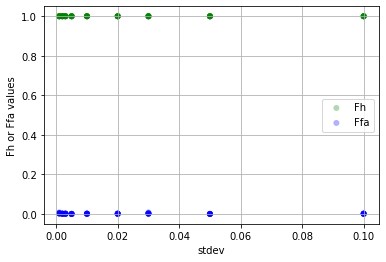

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = 50
x = Fh_noise_array
y = Ffa_noise_array
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)
x.shape, y.shape
# [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
[]
std_plot = [[0.001 for _ in range(10)],
       [0.002 for _ in range(10)],
       [0.003 for _ in range(10)],
       [0.005 for _ in range(10)],
       [0.01 for _ in range(10)],
       [0.02 for _ in range(10)],
       [0.03 for _ in range(10)],
       [0.05 for _ in range(10)],
       [0.1 for _ in range(10)]]
# plt.scatter(std_plot, y, c="blue", alpha=0.5, label="Ffa", loc="upper right")
# plt.scatter(std_plot, x, c="green", alpha=0.5, label="Fh", loc="upper right")
# plt.show()

fig, ax = plt.subplots()

ax.scatter(std_plot, x, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(std_plot, y, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
ax.legend()
plt.show()



[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.004329   0.00210526 0.00141243 0.0021254  0.00170213 0.00142146
 0.001221   0.0010644  0.00094877 0.00085507]


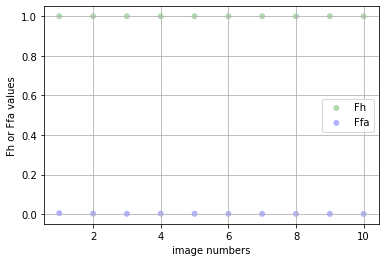

In [15]:
# x = Fh_noise_array
# y = Ffa_noise_array
x = Fh_array
y = Ffa_array

std_plot = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
# std_plot = [[0.001 for _ in range(10)],
#        [0.002 for _ in range(10)],
#        [0.003 for _ in range(10)],
#        [0.005 for _ in range(10)],
#        [0.01 for _ in range(10)],
#        [0.02 for _ in range(10)],
#        [0.03 for _ in range(10)],
#        [0.05 for _ in range(10)],
#        [0.1 for _ in range(10)]]
# plt.scatter(std_plot, y, c="blue", alpha=0.5, label="Ffa", loc="upper right")
# plt.scatter(std_plot, x, c="green", alpha=0.5, label="Fh", loc="upper right")
# plt.show()

print(x, y)

fig, ax = plt.subplots()

ax.scatter([1,2,3,4,5,6,7,8,9,10], x, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter([1,2,3,4,5,6,7,8,9,10], y, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
plt.show()

